# Setup

## Imports

Torch Modules

In [1]:
import torch

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

vai Modules

In [2]:
import vaiutils, vaidata

from vaiutils import path_consts, plot_images, channels_last, smooth_plot, summarize_tensor

Other Modules

In [3]:
import os.path

import torchsample.transforms

from tqdm import tqdm_notebook

## Define Useful Variables and Functions

In [4]:
for k, v in path_consts('horse2zebra', 'Zebra'):
    exec(k + '=v')

In [5]:
DIR_A = os.path.join(DIR_DATA, 'trainA')
DIR_B = os.path.join(DIR_DATA, 'trainB')
DIR_A_TEST = os.path.join(DIR_DATA, 'testA')
DIR_B_TEST = os.path.join(DIR_DATA, 'testB')

In [6]:
def plot_images(images):
    vaiutils.plot_images(images, pixel_range=(-1, 1))

In [7]:
def pickle_dump(filename, obj):
    vaidata.pickle_dump(os.path.join(DIR_CHECKPOINTS, filename + '.p'), obj)

In [8]:
def pickle_load(filename, default=None):
    return vaidata.pickle_load(os.path.join(DIR_CHECKPOINTS, filename + '.p'), default)

## Load Data

In [9]:
batch_size = 1

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                torchsample.transforms.RandomFlip(v=True),
                                torchsample.transforms.RandomRotate(10),
                                torchsample.transforms.RandomTranslate(0.1),
                                torchsample.transforms.RandomZoom((0.9, 1.1)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_A = DataLoader(ImageFolder(DIR_A, transform), batch_size, shuffle=True)
data_B = DataLoader(ImageFolder(DIR_B, transform), batch_size, shuffle=True)
data_A_test = DataLoader(ImageFolder(DIR_A_TEST, transform_test), batch_size=5, shuffle=True)
data_B_test = DataLoader(ImageFolder(DIR_B_TEST, transform_test), batch_size=5, shuffle=True)

In [11]:
batches_per_epoch = int(min(len(data_A), len(data_B)))

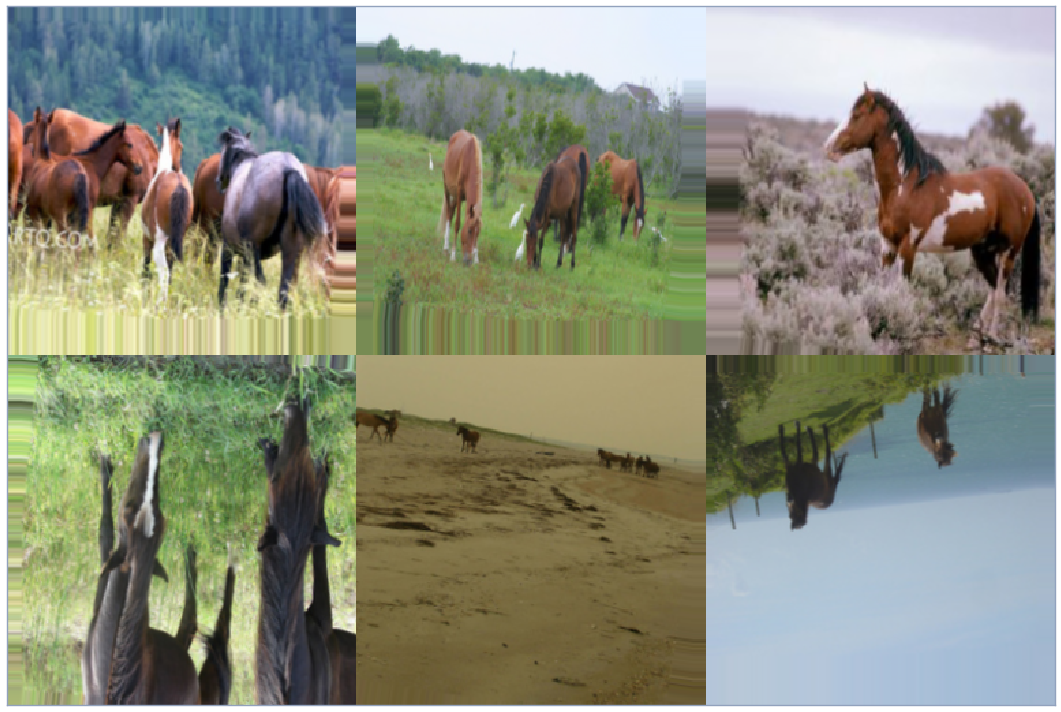

In [12]:
plot_images([channels_last(iter(data_A).next()[0].numpy())[0] for _ in range(6)])

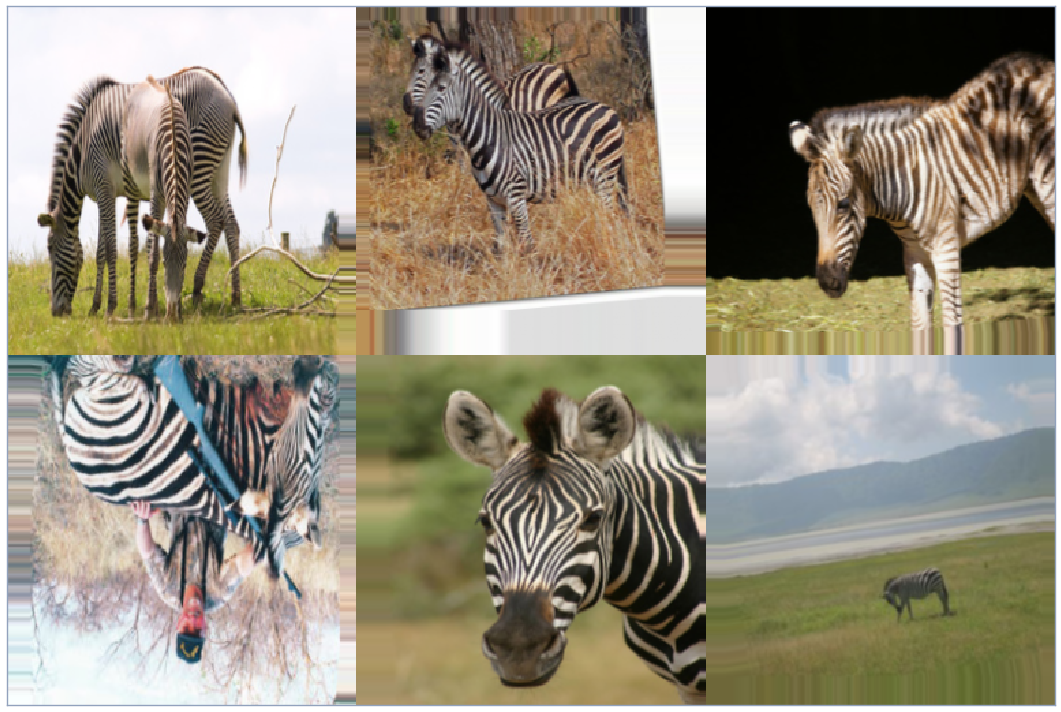

In [13]:
plot_images([channels_last(iter(data_B).next()[0].numpy())[0] for _ in range(6)])

# Create Model

In [14]:
def tconv_block(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0):
    return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding),
                          nn.InstanceNorm2d(out_channels),
                          nn.ReLU(inplace=True))

In [15]:
def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0, norm=True, activation='relu'):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if activation == 'relu':
        layers.append(nn.ReLU(inplace=True))
    elif activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    return nn.Sequential(*layers)

In [16]:
class res_block(nn.Module):
    def __init__(self):
        super().__init__()
        self.residual = nn.Sequential(nn.ReflectionPad2d(1),
                                      conv_block(256, 256, 3),
                                      nn.ReflectionPad2d(1),
                                      conv_block(256, 256, 3, activation=None))
    def forward(self, x):
        return x + self.residual(x)

In [17]:
def init_weights(model):
    for m in model.modules():
        if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
            nn.init.normal(m.weight.data, std=0.02)
        #elif type(m) == nn.InstanceNorm2d:
            #nn.init.constant(m.weight.data, 1)
            #nn.init.constant(m.bias.data, 0)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.reflpad = nn.ReflectionPad2d(3)
        self.conv1 = conv_block(3, 64, 7)
        self.conv2 = conv_block(64, 128, 3, 2, 1)
        self.conv3 = conv_block(128, 256, 3, 2, 1)
        self.res1 = res_block()
        self.res2 = res_block()
        self.res3 = res_block()
        self.res4 = res_block()
        self.res5 = res_block()
        self.res6 = res_block()
        self.tconv1 = conv_block(256, 128, 3, 1, 1)
        self.upsample = nn.Upsample(scale_factor=2)
        self.tconv2 = conv_block(128, 64, 3, 1, 1)
        self.conv4 = conv_block(64, 3, 7, norm=False, activation='tanh')
        
        init_weights(self)
        
    def forward(self, x):
        x = self.reflpad(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.res6(x)
        x = self.upsample(self.tconv1(x))
        x = self.upsample(self.tconv2(x))
        x = self.reflpad(x)
        x = self.conv4(x)
        return x

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64, 4, 2, 1, norm=False, activation='lrelu')
        self.conv2 = conv_block(64, 128, 4, 2, 1, activation='lrelu')
        self.conv3 = conv_block(128, 256, 4, 2, 1, activation='lrelu')
        self.conv4 = conv_block(256, 512, 4, 1, 1, activation='lrelu')
        self.conv5 = conv_block(512, 1, 4, 1, 1, norm=False, activation=None)
        
        init_weights(self)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.squeeze()
        return x

# Train Model

In [20]:
cycle_const = 10
replay_buffer_size = 50

In [21]:
gen_A = Generator().cuda()
gen_B = Generator().cuda()
disc_A = Discriminator().cuda()
disc_B = Discriminator().cuda()

In [22]:
optimizer_g = optim.Adam(list(gen_A.parameters()) + list(gen_B.parameters()), 2e-4)
optimizer_d = optim.Adam(list(disc_A.parameters()) + list(disc_B.parameters()), 1e-4)

In [23]:
criterion_cycle = nn.L1Loss()

In [24]:
history = {'loss_d_A': [], 'loss_d_B': [], 'loss_g_A': [],
           'loss_g_B': [], 'loss_cycle_A': [], 'loss_cycle_B': [], 'epochs': 0}

In [25]:
def save_state():
    torch.save(gen_A.state_dict(), os.path.join(DIR_CHECKPOINTS, 'gen_A.dat'))
    torch.save(gen_B.state_dict(), os.path.join(DIR_CHECKPOINTS, 'gen_B.dat'))
    torch.save(disc_B.state_dict(), os.path.join(DIR_CHECKPOINTS, 'disc_A.dat'))
    torch.save(disc_B.state_dict(), os.path.join(DIR_CHECKPOINTS, 'disc_B.dat'))
    pickle_dump('history', history)
    
def load_state():
    global history
    if not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'gen_A.dat')):
        return
    gen_A.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'gen_A.dat')))
    gen_B.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'gen_B.dat')))
    disc_A.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'disc_A.dat')))
    disc_B.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'disc_B.dat')))
    history = pickle_load('history')

## Training

In [26]:
def optimize(epochs=1, writes_per_epoch=10):
    load_state()
    running_history = {'loss_d_A': [], 'loss_d_B': [], 'loss_g_A': [],
           'loss_g_B': [], 'loss_cycle_A': [], 'loss_cycle_B': []}
    img_pool_A, img_pool_B = [], []
    for epoch in tqdm_notebook(range(history['epochs'], history['epochs'] + epochs)):
        data_iter_A, data_iter_B = iter(data_A), iter(data_B)
        
        prog_bar = tqdm_notebook(range(batches_per_epoch))
        for batch in prog_bar:
            x = Variable(data_iter_A.next()[0].cuda())
            y = Variable(data_iter_B.next()[0].cuda())
            
            x_gen = gen_A(y)
            y_gen = gen_B(x)
            img_pool_A.append(x_gen.data)
            img_pool_B.append(y_gen.data)
            
            # Adverserial Loss
            if len(img_pool_A) > replay_buffer_size:
                p_x_gen = disc_A(Variable(img_pool_A.pop(randint(replay_buffer_size))))
                p_y_gen = disc_B(Variable(img_pool_B.pop(randint(replay_buffer_size))))
            else:
                p_x_gen = disc_A(Variable(x_gen.data))
                p_y_gen = disc_B(Variable(y_gen.data))
                
            p_x = disc_A(x)
            p_y = disc_B(y)
            loss_d_A = ((p_x - 1) ** 2).mean() + (p_x_gen ** 2).mean()
            loss_d_B = ((p_y - 1) ** 2).mean() + (p_y_gen ** 2).mean()
            
            optimizer_d.zero_grad()
            (loss_d_A + loss_d_B).backward()
            optimizer_d.step()
            
            loss_g_A = ((disc_A(x_gen) - 1) ** 2).mean()
            loss_g_B = ((disc_B(y_gen) - 1) ** 2).mean()
            
            # Cycle-Consistancy Loss
            x_hat = gen_A(y_gen)
            y_hat = gen_B(x_gen)
            
            loss_cycle_A = criterion_cycle(x_hat, x)
            loss_cycle_B = criterion_cycle(y_hat, y)
            
            optimizer_g.zero_grad()
            (loss_g_A + loss_g_B + cycle_const * (loss_cycle_A + loss_cycle_B)).backward()
            optimizer_g.step()
                
            running_history['loss_d_A'].append(loss_d_A.data.cpu().numpy()[0])
            running_history['loss_d_B'].append(loss_d_B.data.cpu().numpy()[0])
            running_history['loss_g_A'].append(loss_g_A.data.cpu().numpy()[0])
            running_history['loss_g_B'].append(loss_g_B.data.cpu().numpy()[0])
            running_history['loss_cycle_A'].append(loss_cycle_A.data.cpu().numpy()[0])
            running_history['loss_cycle_B'].append(loss_cycle_B.data.cpu().numpy()[0])
            prog_bar.set_description('{:.2f}%'.format((mean(running_history['loss_cycle_A']) + mean(running_history['loss_cycle_B']))*25))
            if batch % int(batches_per_epoch / writes_per_epoch) == 0:
                for k in running_history.keys():
                    if len(running_history[k]) == 0:
                        continue
                    history[k].append(mean(running_history[k]))
                    running_history[k] = []

        save_state()
        history['epochs'] += 1

In [27]:
optimize(2)

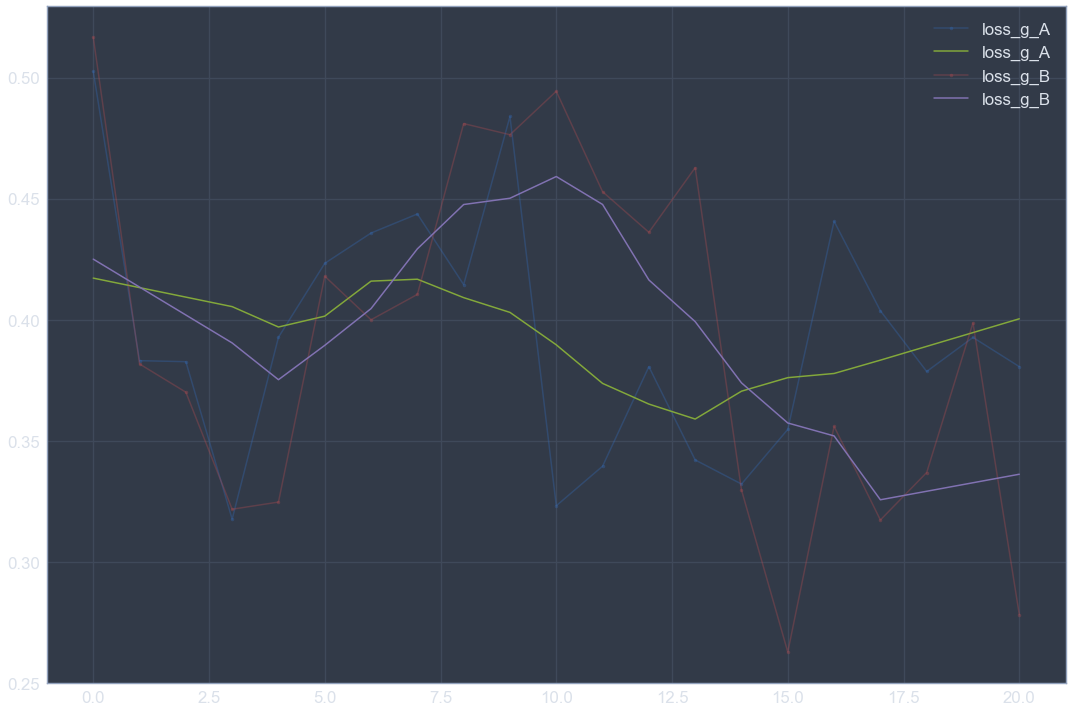

In [28]:
smooth_plot(history, keys=['loss_g_A', 'loss_g_B'])

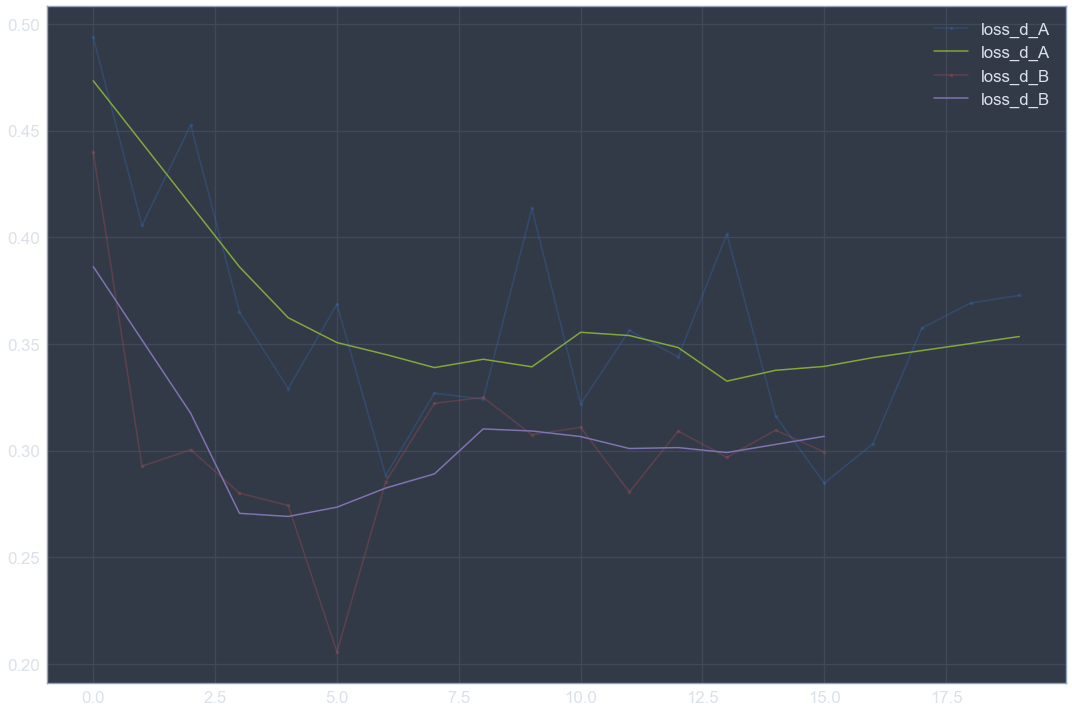

In [29]:
smooth_plot(history, keys=['loss_d_A', 'loss_d_B'])

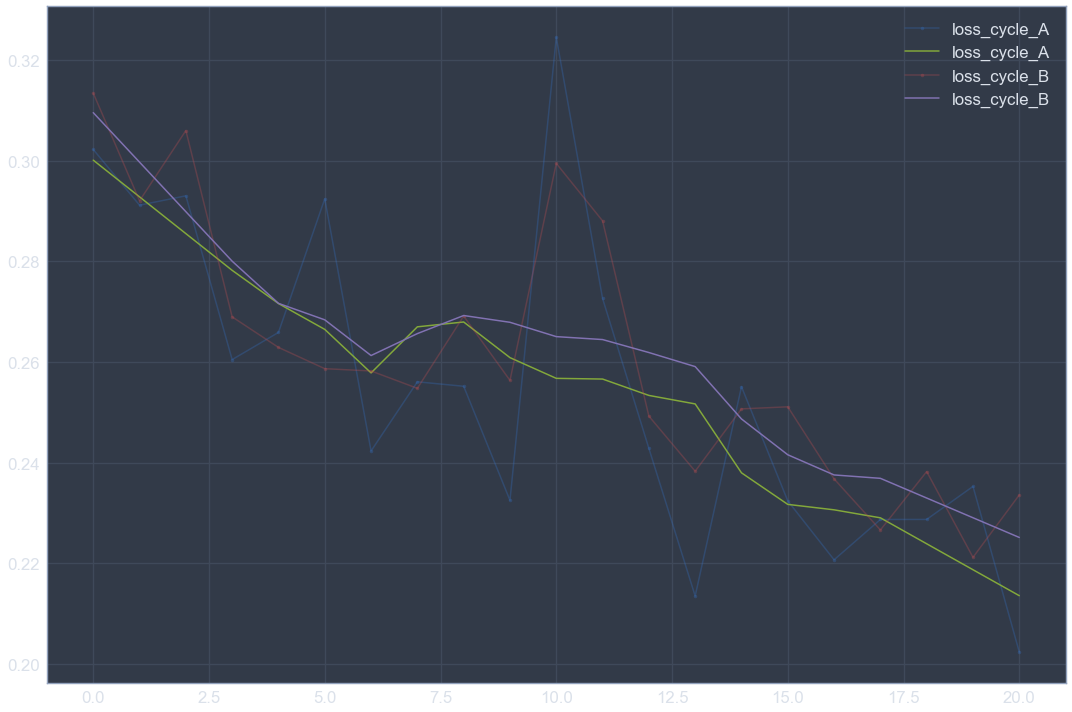

In [30]:
smooth_plot(history, keys=['loss_cycle_A', 'loss_cycle_B'])

# Test Model

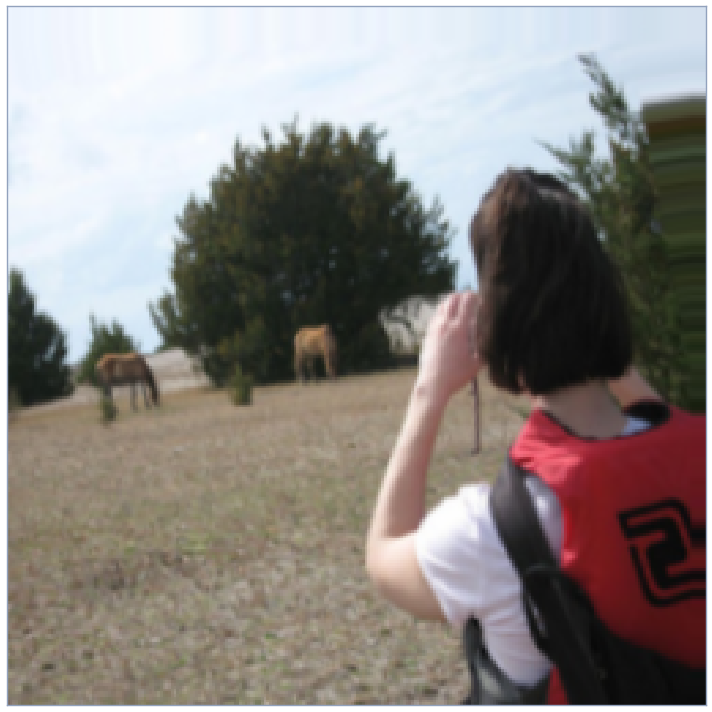

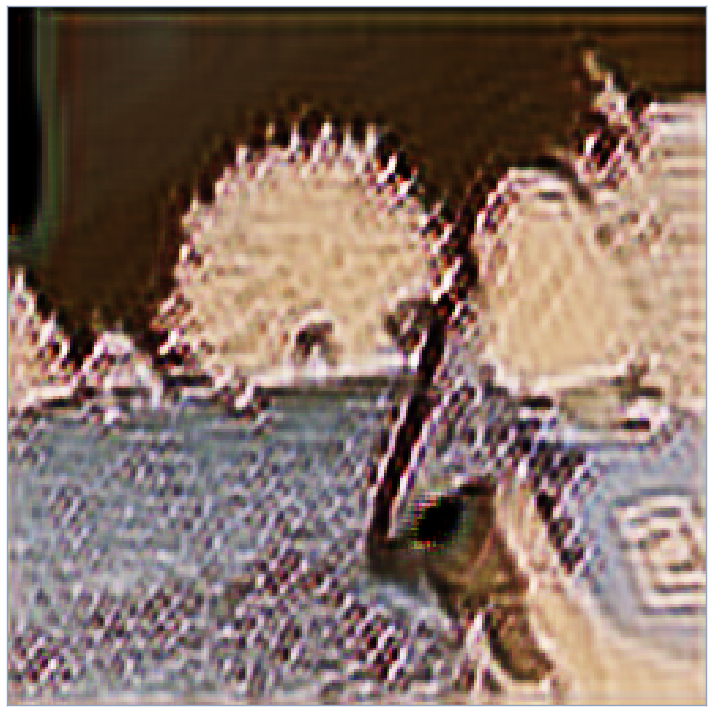

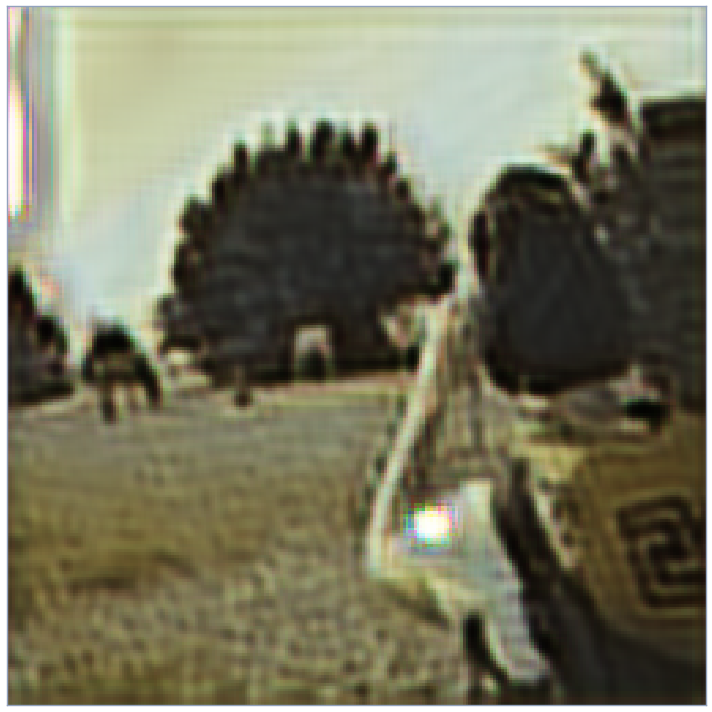

In [31]:
sample_img_A = iter(data_A).next()[0]
sample_gen_img_B = gen_B(sample_img_A.cuda())
plot_images(channels_last(sample_img_A.numpy()))
plot_images(channels_last(sample_gen_img_B.data.cpu().numpy()))
plot_images(channels_last(gen_A(sample_gen_img_B).data.cpu().numpy()))

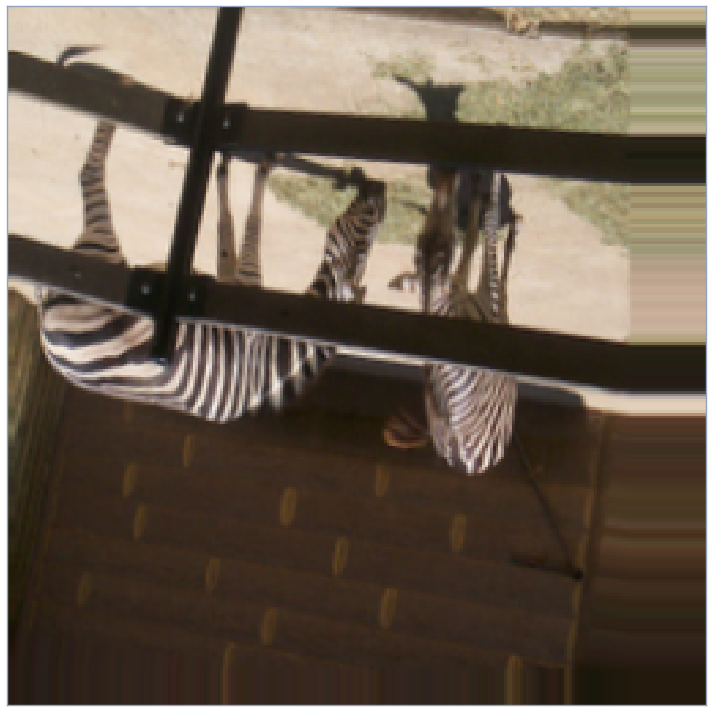

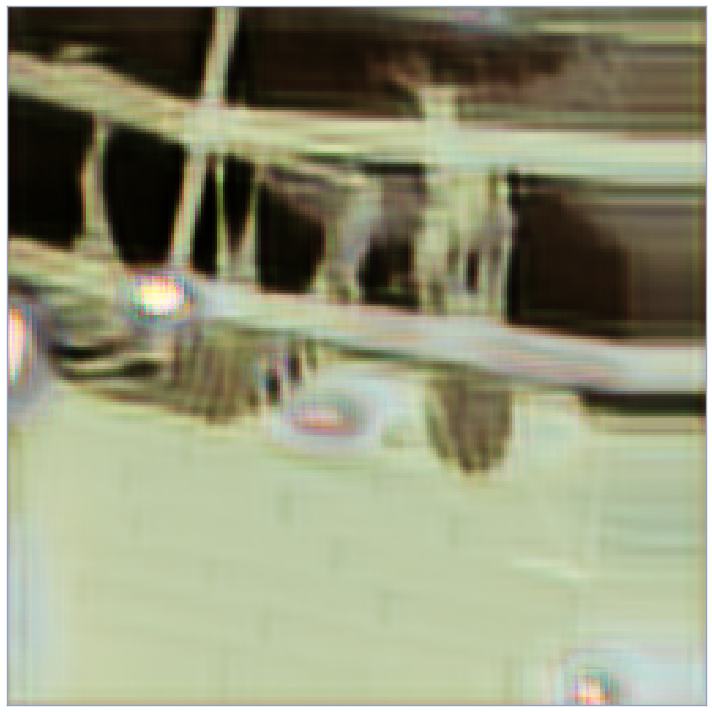

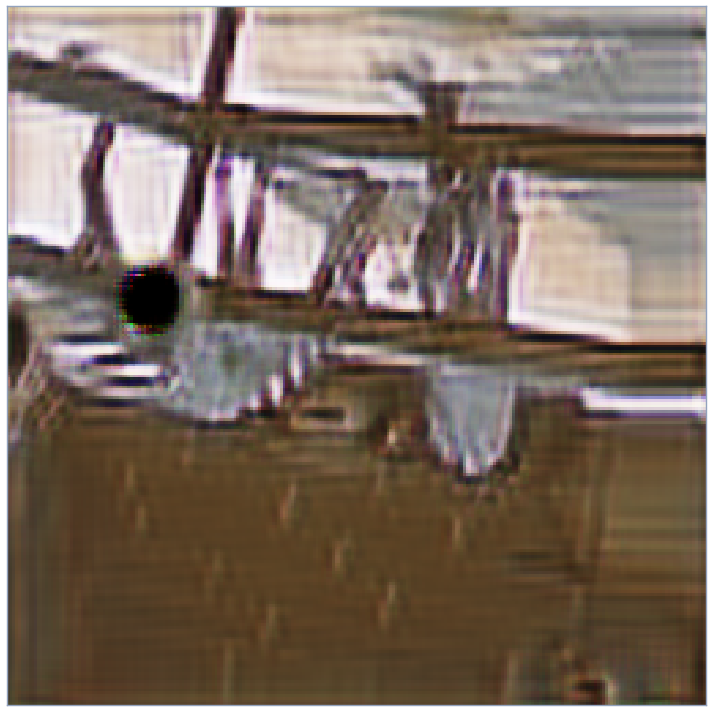

In [32]:
sample_img_B = iter(data_B).next()[0]
sample_gen_img_A = gen_A(sample_img_B.cuda())
plot_images(channels_last(sample_img_B.numpy()))
plot_images(channels_last(sample_gen_img_A.data.cpu().numpy()))
plot_images(channels_last(gen_B(sample_gen_img_A).data.cpu().numpy()))